In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import f1_score, classification_report, confusion_matrix
from joblib import load, dump

import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random

import warnings
warnings.filterwarnings('ignore')

In [2]:
train_df = pd.read_csv('../BOW_PROJECT/tokenized/khmer_news_train_tokenized.csv', encoding='utf-8-sig')
val_df   = pd.read_csv('../BOW_PROJECT/tokenized/khmer_news_val_tokenized.csv', encoding=' utf-8-sig')
test_df  = pd.read_csv('../BOW_PROJECT/tokenized/khmer_news_test_tokenized.csv', encoding='utf-8-sig')

In [3]:
print(f"  - train_tokenized.csv ({len(train_df)} samples)")
print(f"  - val_tokenized.csv ({len(val_df)} samples)")
print(f"  - test_tokenized.csv ({len(test_df)} samples)")

  - train_tokenized.csv (5140 samples)
  - val_tokenized.csv (661 samples)
  - test_tokenized.csv (1543 samples)


In [4]:
X_train_text = train_df['content']
y_train = train_df['label']

X_val_text = val_df['content']
y_val = val_df['label']

X_test_text = test_df['content']
y_test = test_df['label']

# **TF-IDF Vectorization + TruncatedSVD**

In [5]:
tf_idf = TfidfVectorizer(
    analyzer=str.split,
    max_features=None,      #max_features is NOT required when using TruncatedSVD ✔ Let SVD control dimensionality
    min_df=3,
    max_df=0.85,
    ngram_range=(1, 2)
)

X_train_tf_idf = tf_idf.fit_transform(train_df['content'])
X_val_tf_idf  = tf_idf.transform(val_df['content'])
X_test_tf_idf  = tf_idf.transform(test_df['content'])

print(f"Vocabulary size: {len(tf_idf.vocabulary_):,}")
print(f"tf_idf shape (train): {X_train_tf_idf.shape}")
print(f"tf_idf shape (val): {X_val_tf_idf.shape}")
print(f"tf_idf shape (test): {X_test_tf_idf.shape}")

Vocabulary size: 13,222
tf_idf shape (train): (5140, 13222)
tf_idf shape (val): (661, 13222)
tf_idf shape (test): (1543, 13222)


In [6]:
import numpy as np

LABEL_MAP = {
    0: "economic",
    1: "entertainment",
    2: "life",
    3: "politic",
    4: "sport",
    5: "technology"
}
feature_names = np.array(tf_idf.get_feature_names_out())
TOP_N = 10

print("=" * 80)
print("TOP TF-IDF TERMS PER CATEGORY")
print("=" * 80)

for label_id, label_name in LABEL_MAP.items():

    # select documents belonging to this class
    pos_mask = (y_train == label_id).to_numpy()
    pos_count = pos_mask.sum()

    print(f"\n{label_name.upper():<12}")

    if pos_count == 0:
        print("No samples")
        continue

    # mean TF-IDF vector for the class
    class_mean_tfidf = np.asarray(
        X_train_tf_idf[pos_mask].mean(axis=0)
    ).ravel()

    # top-N terms
    top_indices = np.argsort(class_mean_tfidf)[-TOP_N:][::-1]

    print("-" * 50)
    print(f"Samples: {pos_count}")
    print("-" * 50)

    for rank, idx in enumerate(top_indices, start=1):
        term = feature_names[idx]
        score = class_mean_tfidf[idx]
        print(f"{rank:2}. {term:<25} {score:.6f}")

TOP TF-IDF TERMS PER CATEGORY

ECONOMIC    
--------------------------------------------------
Samples: 851
--------------------------------------------------
 1. កម្ពុជា                   0.086050
 2. លោក                       0.065491
 3. ប្រទេស                    0.062549
 4. ក្រុមហ៊ុន                 0.053861
 5. ពាណិជ្ជកម្ម               0.052451
 6. សេដ្ឋកិច្ច                0.049613
 7. ភាគរយ                     0.049018
 8. ឆ្នាំ                     0.048238
 9. លាន                       0.043406
10. ដុល្លារ                   0.043199

ENTERTAINMENT
--------------------------------------------------
Samples: 700
--------------------------------------------------
 1. នាង                       0.072710
 2. តារា                      0.055329
 3. ជា                        0.048213
 4. រឿង                       0.043206
 5. លោក                       0.039212
 6. សម្តែង                    0.036842
 7. ពី                        0.034102
 8. មិន                       0.033582
 9. ភាពយន

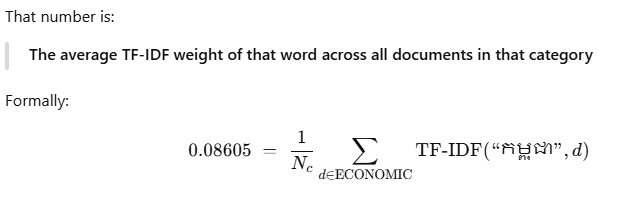

### Explained Variance by TruncatedSVD Components

Let's visualize how much variance each component explains to help us choose the optimal number of components for our model.

Components needed for >=80% variance: 1385 (actual: 0.8001)
Components needed for >=85% variance: 1715 (actual: 0.8501)
Components needed for >=90% variance: 2165 (actual: 0.9000)


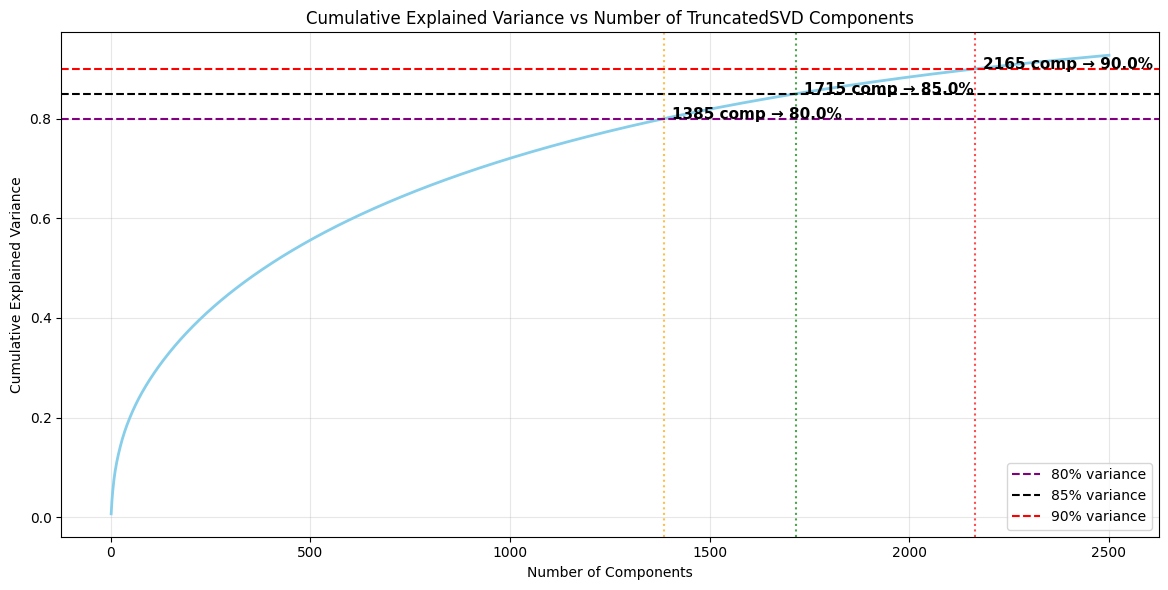

In [7]:
max_components = min(4000, X_train_tf_idf.shape[1] - 1)

svd_full = TruncatedSVD(n_components=max_components, random_state=42)
svd_full.fit(X_train_tf_idf)

cumulative_variance = np.cumsum(svd_full.explained_variance_ratio_)

# Find the smallest n where variance >= target
targets = [0.80, 0.85, 0.90]
optimal_ns = {}

for target in targets:
    n = np.argmax(cumulative_variance >= target) + 1
    optimal_ns[target] = n
    print(f"Components needed for >={target*100:.0f}% variance: {n} (actual: {cumulative_variance[n-1]:.4f})")

plt.figure(figsize=(12, 6))
plt.plot(range(1, len(cumulative_variance[:2500])+1), cumulative_variance[:2500],
         color='skyblue', linewidth=2)
plt.axhline(y=0.80, color='purple', linestyle='--', label='80% variance')
plt.axhline(y=0.85, color='black', linestyle='--', label='85% variance')
plt.axhline(y=0.90, color='red', linestyle='--', label='90% variance')

for target, n in optimal_ns.items():
    if n <= 2500:
        plt.axvline(x=n, color={0.80:'orange', 0.85:'green', 0.90:'red'}[target],
                    linestyle=':', alpha=0.7)
        plt.text(n+20, target, f'{n} comp → {target*100}%', fontsize=11, fontweight='bold')

plt.title("Cumulative Explained Variance vs Number of TruncatedSVD Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [8]:
n_components = min(X_train_tf_idf.shape[0]-1, X_train_tf_idf.shape[1]-1, 1715)

svd = TruncatedSVD(n_components=n_components, random_state=42)
X_train_svd = svd.fit_transform(X_train_tf_idf)
X_val_svd = svd.transform(X_val_tf_idf)
X_test_svd = svd.transform(X_test_tf_idf)

print(f"TruncatedSVD shape (train): {X_train_svd.shape}")
print(f"TruncatedSVD shape (val): {X_val_svd.shape}")
print(f"TruncatedSVD shape (test): {X_test_svd.shape}")

TruncatedSVD shape (train): (5140, 1715)
TruncatedSVD shape (val): (661, 1715)
TruncatedSVD shape (test): (1543, 1715)


## 2D Visualization

2D SVD shape: (5140, 2)
Explained variance ratio: [0.00702992 0.01391325]


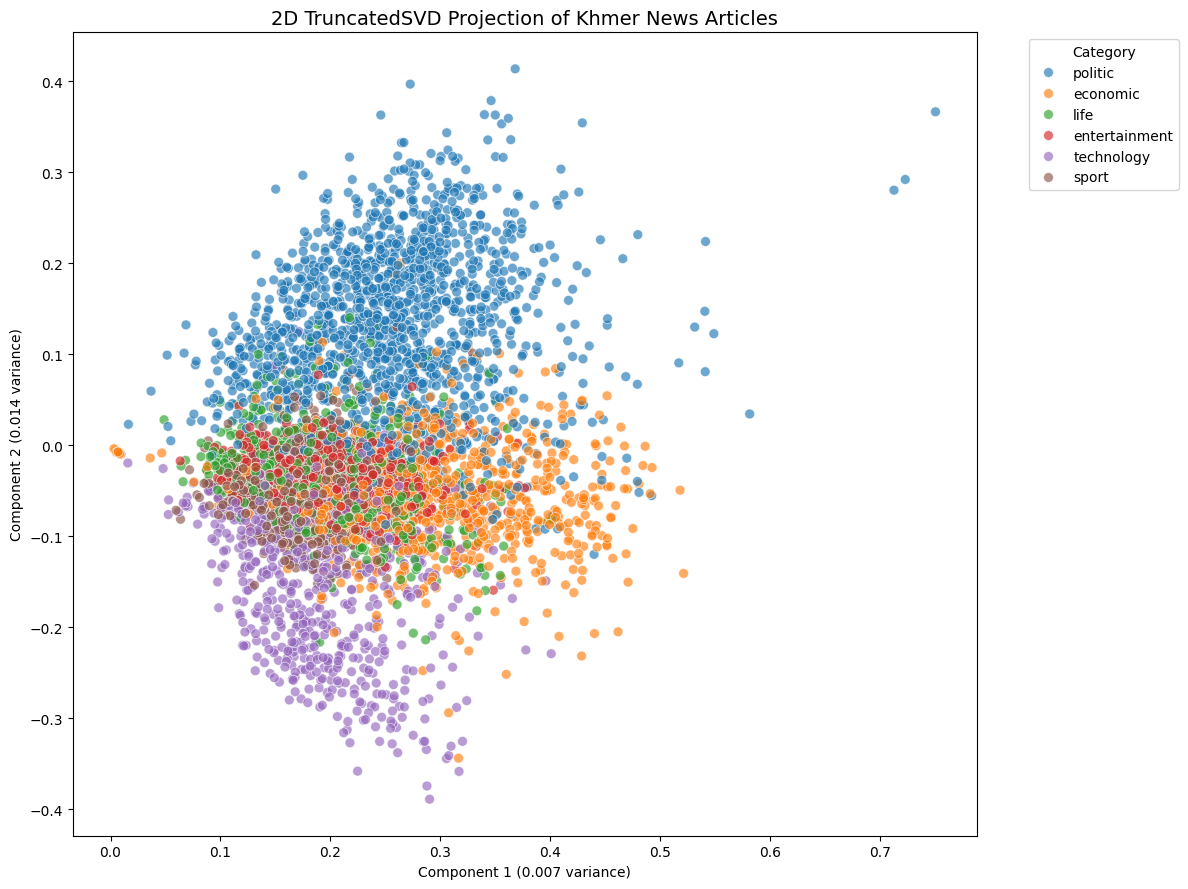

In [9]:
# -----------------------------
# 2D Visualization of Separability
# -----------------------------
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import TruncatedSVD

# --------------------------------------------------
# We already have:
# X_train_tf_idf -> sparse TF-IDF matrix
# y_train        -> pandas Series of integer labels (0-5)
# LABEL_MAP      -> dictionary mapping int -> category name
# --------------------------------------------------

# Step 1: 2D TruncatedSVD
svd_2d = TruncatedSVD(n_components=2, random_state=42)
X_train_2d = svd_2d.fit_transform(X_train_tf_idf)

print(f"2D SVD shape: {X_train_2d.shape}")
print("Explained variance ratio:", svd_2d.explained_variance_ratio_)

# Step 2: Convert integer labels to category names
labels_2d = y_train.map(LABEL_MAP)

# Step 3: Plot the 2D projection
plt.figure(figsize=(12, 9))
sns.scatterplot(
    x=X_train_2d[:, 0],
    y=X_train_2d[:, 1],
    hue=labels_2d,
    palette="tab10",
    alpha=0.65,
    s=50
)

plt.title("2D TruncatedSVD Projection of Khmer News Articles", fontsize=14)
plt.xlabel(f"Component 1 ({svd_2d.explained_variance_ratio_[0]:.3f} variance)")
plt.ylabel(f"Component 2 ({svd_2d.explained_variance_ratio_[1]:.3f} variance)")
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

## 3D Visualization

3D SVD shape: (5140, 3)
Explained variance ratio: [0.00702992 0.01391333 0.01307386]


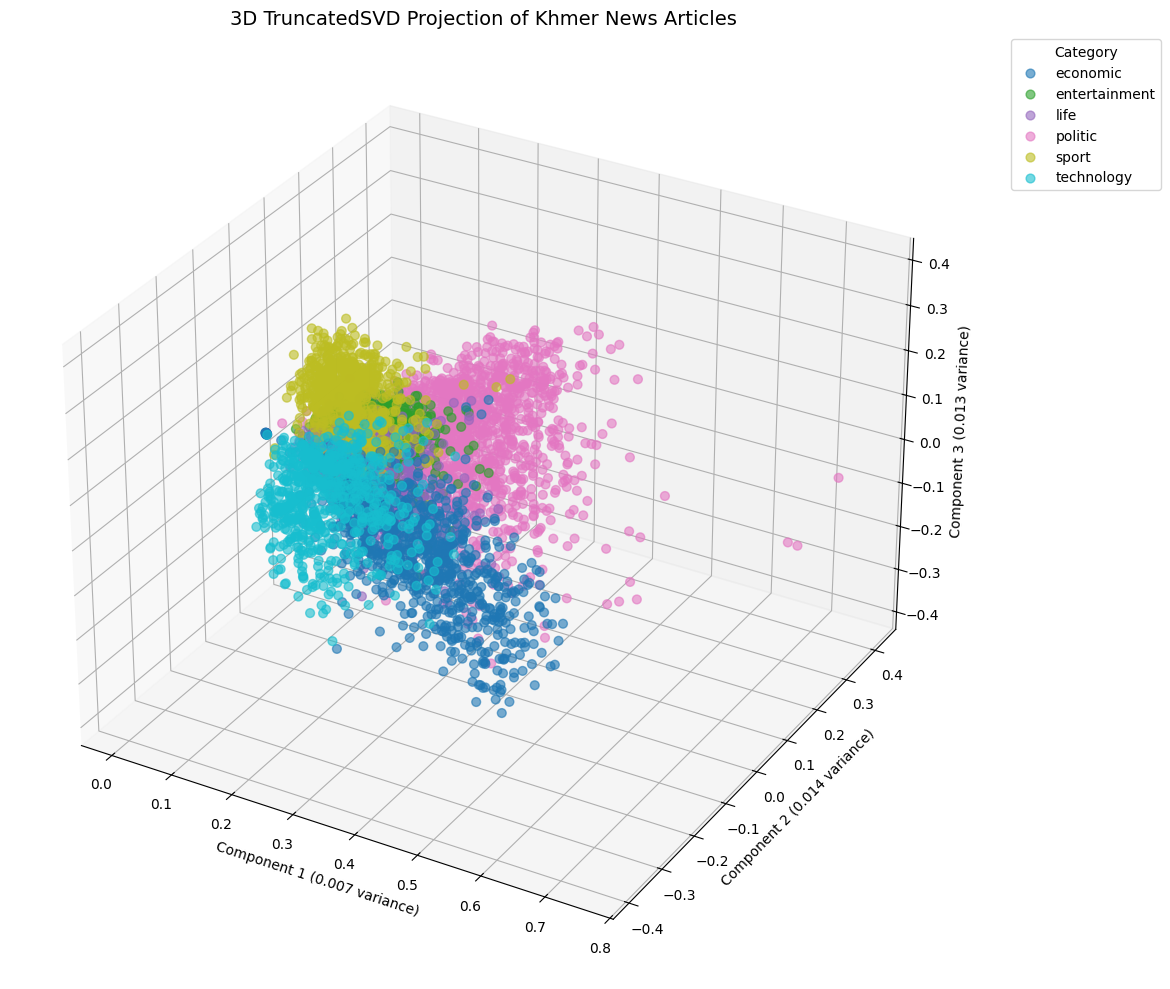

In [10]:
# -----------------------------
# 3D Visualization of Class Separability
# -----------------------------
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import TruncatedSVD

# --------------------------------------------------
# We already define:
# X_train_tf_idf -> sparse TF-IDF matrix (train data)
# y_train        -> pandas Series of integer labels (0-5)
# LABEL_MAP      -> dictionary mapping int -> category name
# --------------------------------------------------

# Step 1: 3D TruncatedSVD
svd_3d = TruncatedSVD(n_components=3, random_state=42)
X_train_3d = svd_3d.fit_transform(X_train_tf_idf)

print(f"3D SVD shape: {X_train_3d.shape}")
print("Explained variance ratio:", svd_3d.explained_variance_ratio_)

# Step 2: Map integer labels to category names
labels_3d = y_train.map(LABEL_MAP)

# Step 3: Create 3D scatter plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Assign a unique color for each category
categories = list(LABEL_MAP.values())
colors = plt.cm.tab10(np.linspace(0, 1, len(categories)))

for i, category in enumerate(categories):
    mask = labels_3d == category
    ax.scatter(
        X_train_3d[mask, 0],
        X_train_3d[mask, 1],
        X_train_3d[mask, 2],
        label=category,
        color=colors[i],
        s=40,
        alpha=0.6
    )

# Step 4: Set labels and title
ax.set_xlabel(f"Component 1 ({svd_3d.explained_variance_ratio_[0]:.3f} variance)")
ax.set_ylabel(f"Component 2 ({svd_3d.explained_variance_ratio_[1]:.3f} variance)")
ax.set_zlabel(f"Component 3 ({svd_3d.explained_variance_ratio_[2]:.3f} variance)")
ax.set_title("3D TruncatedSVD Projection of Khmer News Articles", fontsize=14)
ax.legend(title="Category", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


# Train Classifiers with Class Imbalance Handling

In [11]:
# =========================================================
# Build classifiers function
# =========================================================
def build_classifiers(random_state: int = 42):
    """
    Build a dictionary of classifiers for BoW + PCA text classification.
    """
    models = {}

    # Logistic Regression
    models["logistic"] = LogisticRegression(
        penalty="l2",
        C=0.8,
        solver="liblinear",
        max_iter=2000,
        class_weight="balanced",
        random_state=random_state
    )

    # Linear SVM
    models["svm"] = LinearSVC(
        C=0.1,
        loss="squared_hinge",
        class_weight="balanced",
        max_iter=3000,
        random_state=random_state
    )

    # Random Forest
    models["random_forest"] = RandomForestClassifier(
        n_estimators=400,
        max_depth=25,
        min_samples_split=4,
        min_samples_leaf=2,
        class_weight="balanced",
        n_jobs=-1,
        random_state=random_state
    )

    # XGBoost
    models["xgboost"] = XGBClassifier(
        n_estimators=600,
        learning_rate=0.07,
        max_depth=6,
        subsample=0.85,
        colsample_bytree=0.85,
        objective="multi:softmax",
        num_class=6,
        eval_metric="mlogloss",
        tree_method="hist",
        n_jobs=-1,
        random_state=random_state
    )

    return models

In [ ]:
# =========================================================
# Train and evaluate classifiers with TF-IDF & TruncatedSVD
# =========================================================
from sklearn.metrics import f1_score, classification_report

label_cols = ['economic', 'entertainment', 'life', 'politic', 'sport', 'technology']
results = {}

print("\nTraining and evaluating models (TF-IDF + TruncatedSVD)...\n")

classifiers = build_classifiers(random_state=42)

for model_name, model in classifiers.items():
    print(f"→ Training {model_name}...")

    # Fit model on svd training data
    model.fit(X_train_svd, y_train)

    # Predict on validation set
    y_pred = model.predict(X_val_svd)

    # Compute macro F1 score
    macro_f1 = f1_score(y_val, y_pred, average="macro", zero_division=0)
    results[model_name] = macro_f1

    # Print classification report
    print(f"{model_name} — Validation Macro F1: {macro_f1:.4f}")
    print(classification_report(
        y_val,
        y_pred,
        target_names=label_cols,
        zero_division=0
    ))
    print("-" * 60)

# =========================================================
# Summary of results
# =========================================================
print("\nValidation Macro F1 scores for all models:")
for model_name, score in results.items():
    print(f"{model_name}: {score:.4f}")


Training and evaluating models (TF-IDF + TruncatedSVD)...

→ Training logistic...
logistic — Validation Macro F1: 0.9036
               precision    recall  f1-score   support

     economic       0.88      0.88      0.88       109
entertainment       0.96      0.91      0.94        90
         life       0.78      0.84      0.81        90
      politic       0.93      0.96      0.95       192
        sport       0.97      0.97      0.97        90
   technology       0.94      0.83      0.88        90

     accuracy                           0.91       661
    macro avg       0.91      0.90      0.90       661
 weighted avg       0.91      0.91      0.91       661

------------------------------------------------------------
→ Training svm...
svm — Validation Macro F1: 0.9194
               precision    recall  f1-score   support

     economic       0.91      0.91      0.91       109
entertainment       0.97      0.94      0.96        90
         life       0.83      0.84      0.84  

## Confusion matrix per category

Plotting confusion matrix for best model: svm


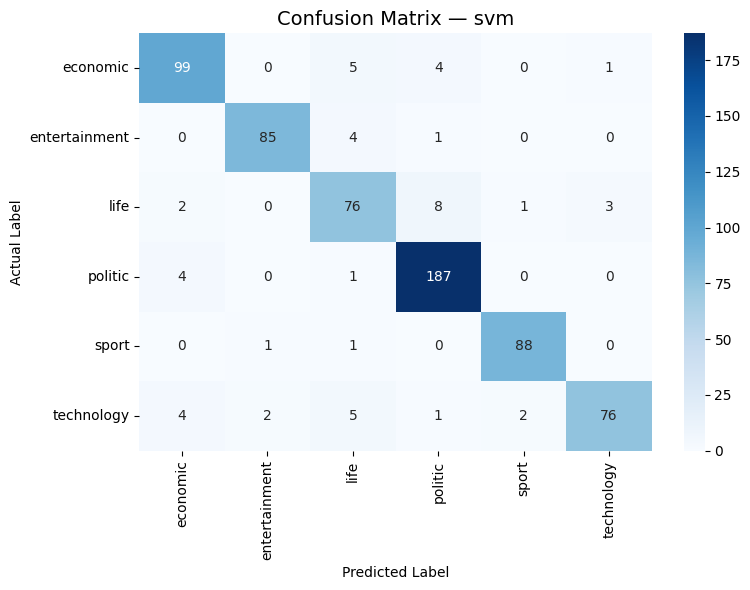

In [13]:
# =========================================================
# Confusion Matrix for Best Model
# =========================================================
# Identify the best model
best_model_name = max(results, key=results.get)
best_clf = classifiers[best_model_name]

# Predict on validation set
y_pred_best = best_clf.predict(X_val_svd)

print(f"Plotting confusion matrix for best model: {best_model_name}")

# Compute confusion matrix
cm = confusion_matrix(y_val, y_pred_best)

# Plot using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=label_cols,
    yticklabels=label_cols
)

plt.title(f"Confusion Matrix — {best_model_name}", fontsize=14)
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.tight_layout()
plt.show()

## Saving model

In [ ]:
# =========================================================
# Save models and preprocessing objects
# =========================================================
from joblib import dump
import os
import pandas as pd

# -----------------------------
# 0. Directory to save everything
# -----------------------------
save_dir = '../BOW_PROJECT/models/tfidf_models_with_truncatedSVD'
os.makedirs(save_dir, exist_ok=True)

# -----------------------------
# 1. Save each trained classifier
# -----------------------------
dump(classifiers["logistic"], os.path.join(save_dir, 'logistic_regression_model.joblib'))
dump(classifiers["svm"], os.path.join(save_dir, 'linear_svm_model.joblib'))
dump(classifiers["random_forest"], os.path.join(save_dir, 'random_forest_model.joblib'))
dump(classifiers["xgboost"], os.path.join(save_dir, 'xgboost_model.joblib'))

# Also save the TFIDFVectorizer
dump(tf_idf, f'{save_dir}/tf_idf_vectorizer.joblib')

# -----------------------------
# 2. Save preprocessing objects
# -----------------------------

# Save the svd object used to create X_train_svd
dump(svd, os.path.join(save_dir, 'svd.joblib'))

# -----------------------------
# 3. Save class labels (for inference)
# -----------------------------
pd.DataFrame(label_cols, columns=["label"]).to_csv(os.path.join(save_dir, 'classes.csv'), index=False)

print("✅ Models, preprocessors, and class labels saved successfully!")

✅ Models, preprocessors, and class labels saved successfully!


## Testing

In [ ]:
import re
import numpy as np
import pandas as pd
from joblib import load
from khmernltk import word_tokenize

# -----------------------------
# 1. Load saved objects
# -----------------------------
# Load everything
tfidf = load('../BOW_PROJECT/models/tfidf_models_with_truncatedSVD/tf_idf_vectorizer.joblib')
svd   = load('../BOW_PROJECT/models/tfidf_models_with_truncatedSVD/svd.joblib')
svm_loaded = load('../BOW_PROJECT/models/tfidf_models_with_truncatedSVD/linear_svm_model.joblib')
classes   = pd.read_csv('../BOW_PROJECT/models/tfidf_models_with_truncatedSVD/classes.csv')['label'].tolist()

# -----------------------------
# 2. Preprocessing functions
# -----------------------------
def clean_khmer_text(text: str) -> str:
    if not isinstance(text, str):
        return ""

    text = re.sub(r'<[^>]+>', '', text)                    # remove HTML
    text = re.sub(r'[\u200B-\u200D\uFEFF]', '', text)      # zero-width chars
    text = re.sub(
        r'[!"#$%&\'()*+,—./:;<=>?@[\]^_`{|}~។៕៖ៗ៘៙៚៛«»-]',
        ' ',
        text
    )
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def khmer_tokenize(text: str) -> str:
    """
    Clean and tokenize Khmer text using khmer-nltk.
    Output is a SPACE-separated token string
    (required for TFIDFtVectorizer(analyzer=str.split))
    """
    cleaned = clean_khmer_text(text)
    if not cleaned:
        return ""

    tokens = word_tokenize(cleaned, return_tokens=True)

    # filter empty tokens
    tokens = [tok for tok in tokens if tok.strip()]

    return " ".join(tokens)


# -----------------------------
# 3. Prediction function
# -----------------------------
def predict_khmer_text(text: str):
    # 1. Preprocess
    tokenized_text = khmer_tokenize(text)
    if not tokenized_text:
        return "No valid text to predict"

    # 2. TF-IDF
    tf_idf_vec = tfidf.transform([tokenized_text])

    # 3. truncatedSVD
    tf_idf_svd = svd.transform(tf_idf_vec.toarray())

    # 4. Predict (MULTI-CLASS)
    pred = model.predict(tf_idf_svd)   # shape: (1,)

    class_index = int(pred[0])
    return classes[class_index]


# -----------------------------
# 4. Test
# -----------------------------
new_text = "រដ្ឋាភិបាលជប៉ុន សូមស្វាគមន៍លទ្ធផលកិច្ចប្រជុំគណៈកម្មាធិការព្រំដែនទូទៅរវាងកម្ពុជា និងថៃ ដែលបានធ្វើឡើងនៅម៉ាឡេស៊ី នៅថ្ងៃទី២៣ ខែតុលា។ នេះបើតាមសេចក្តីថ្លែងការណ៍របស់លោក Kitamura Toshihiro អ្នកនាំពាក្យក្រសួងការបរទេសជប៉ុន។"

predicted_category = predict_khmer_text(new_text)
print("Predicted category:", predicted_category)

Predicted category: politic


In [21]:
print(khmer_tokenize(new_text))

រដ្ឋាភិបាល ជប៉ុន សូមស្វាគមន៍ លទ្ធផល កិច្ចប្រជុំ គណៈកម្មាធិការ ព្រំដែន ទូទៅ រវាង កម្ពុជា និង ថៃ ដែល បាន ធ្វើឡើង នៅ ម៉ាឡេស៊ី នៅ ថ្ងៃទី ២៣ ខែតុលា នេះ បើ តាម សេចក្តីថ្លែងការណ៍ របស់ លោក Kitamura Toshihiro អ្នកនាំពាក្យ ក្រសួង ការបរទេស ជប៉ុន
